In this notebook, we want to test two time series methods:
* Double Seasonal ARIMA (daily and weekly period)
* TBATS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dat_pred = pd.read_csv('dat_pred.csv')
dat_pred.set_index('label',inplace=True)
dat_pred

,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,2016-01-01 06:00:00,2016-01-01 07:00:00,2016-01-01 08:00:00,2016-01-01 09:00:00,...,2016-04-19 14:00:00,2016-04-19 15:00:00,2016-04-19 16:00:00,2016-04-19 17:00:00,2016-04-19 18:00:00,2016-04-19 19:00:00,2016-04-19 20:00:00,2016-04-19 21:00:00,2016-04-19 22:00:00,2016-04-19 23:00:00
label,,,,,,,,,,,,,,,,,,,,,
0,61.873220,49.990104,44.570139,41.803168,40.641710,42.821441,48.956424,52.547396,61.527604,72.449002,...,69.143273,75.656382,91.246292,111.260064,100.217029,97.945312,95.725106,86.971133,81.889831,59.005297
1,68.859574,57.966499,53.056144,52.190148,50.031250,48.941472,49.696041,47.935911,50.391155,56.842360,...,54.629541,48.239844,52.168750,69.911914,80.749023,81.361523,94.566602,98.646680,104.058008,92.462891
2,64.163450,71.818857,62.878906,61.840227,62.133502,69.336703,81.362439,101.130515,114.178615,110.524203,...,39.398026,35.428865,46.998355,40.039885,57.417352,74.376234,71.671053,65.210938,66.986020,36.548109
3,52.838661,42.563790,43.763188,38.996560,41.146466,38.483945,38.754408,44.410981,52.373280,54.531537,...,44.121277,47.579773,54.371826,69.906738,105.550293,114.797180,108.977539,110.336060,83.884888,65.273926
4,94.670573,85.461263,55.282878,44.813802,113.249674,111.484049,74.604818,71.102865,77.427572,98.029785,...,64.653764,62.509233,53.334517,49.213778,99.255682,97.951349,103.032315,85.398793,82.215199,63.832031


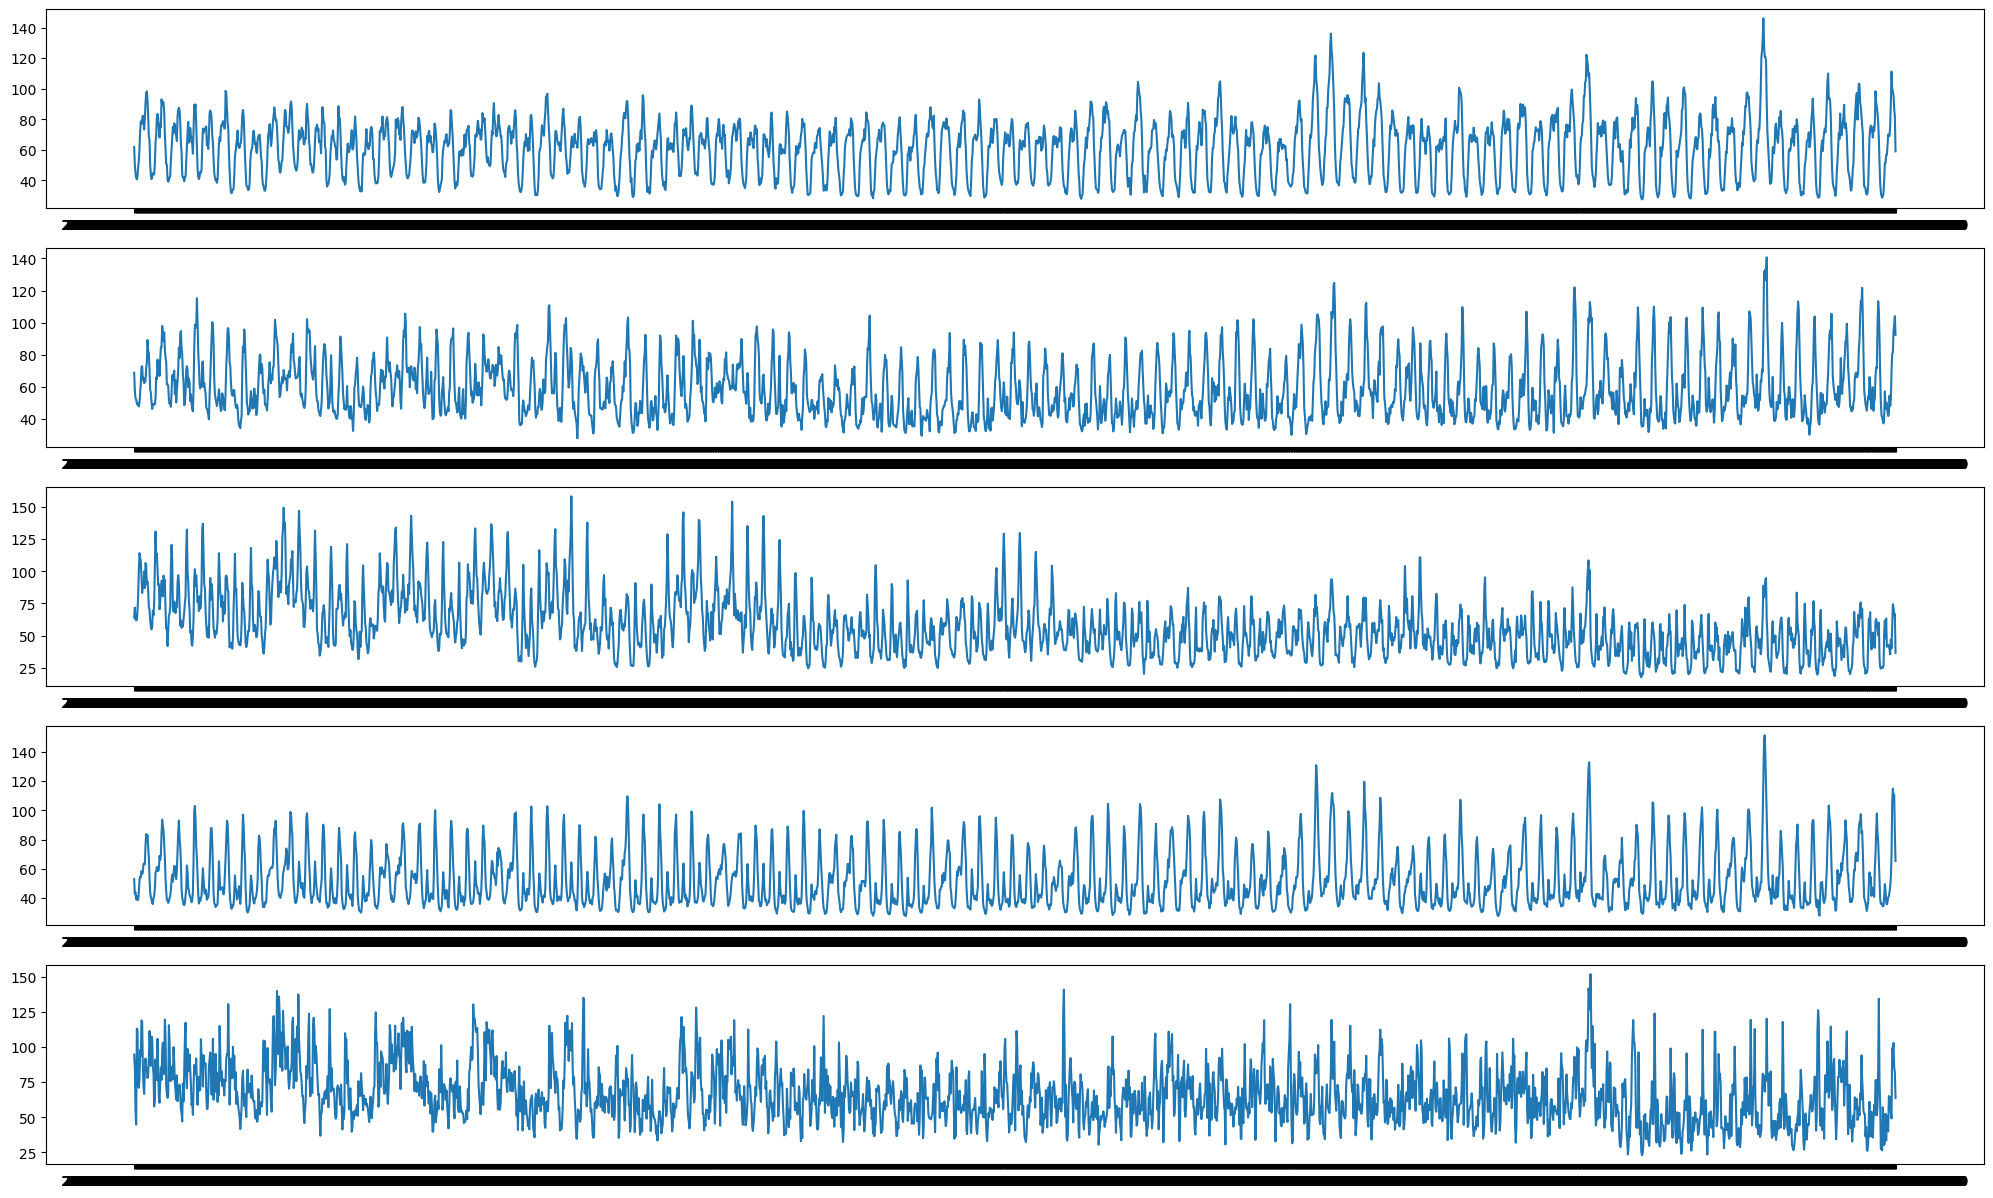

In [3]:
# sample plots
fig = plt.figure(figsize=(25,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(dat_pred.iloc[i,:])

From the plots, we can see some obvious pattern of specific clusters. Cluster 1 is the most smooth. Cluster 2 shows fluctuations at the bottom. Cluster 4 has spikes, and cluster 5 has high volatility in general. 

Note that the $3^{rd}$ series is not homogeneous throughou the time. The start phase shows seasonal pattern, and has higher peak value. In the second half, the seasonal pattern is invisible to human eye. One of the possible reasons is that as some users leave, the characteristics of the cluster change significantly and it is not appropriate to group the left users into one cluster.  

# Double Seasonal ARIMA

Elements of SARIMA model:

1. trend element. same as ARIMA.
* p: Trend autoregression order.
* d: Trend difference order.
* q: Trend moving average order.

2. seasonal element.
* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.


In [4]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [6]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.9/601.9 kB 6.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from pmdarima import auto_arima
from pmdarima.preprocessing import FourierFeaturizer

In [8]:
# sample train and test data for preliminary analysis
train_1= dat_pred.iloc[0,:720]
test_1 = dat_pred.iloc[0,720:960]

In [9]:
# Prepare the fourier terms to add as exogenous features to auto_arima
# Annual seasonality covered by fourier terms
four_terms = FourierFeaturizer(168,2)
y_prime, exog = four_terms.fit_transform(dat_pred.iloc[0,:960])
exog['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = 'H'
exog = exog.drop(columns=['date'])
exog.head()

exog_train = exog.iloc[:720]
exog_test = exog.iloc[720:]

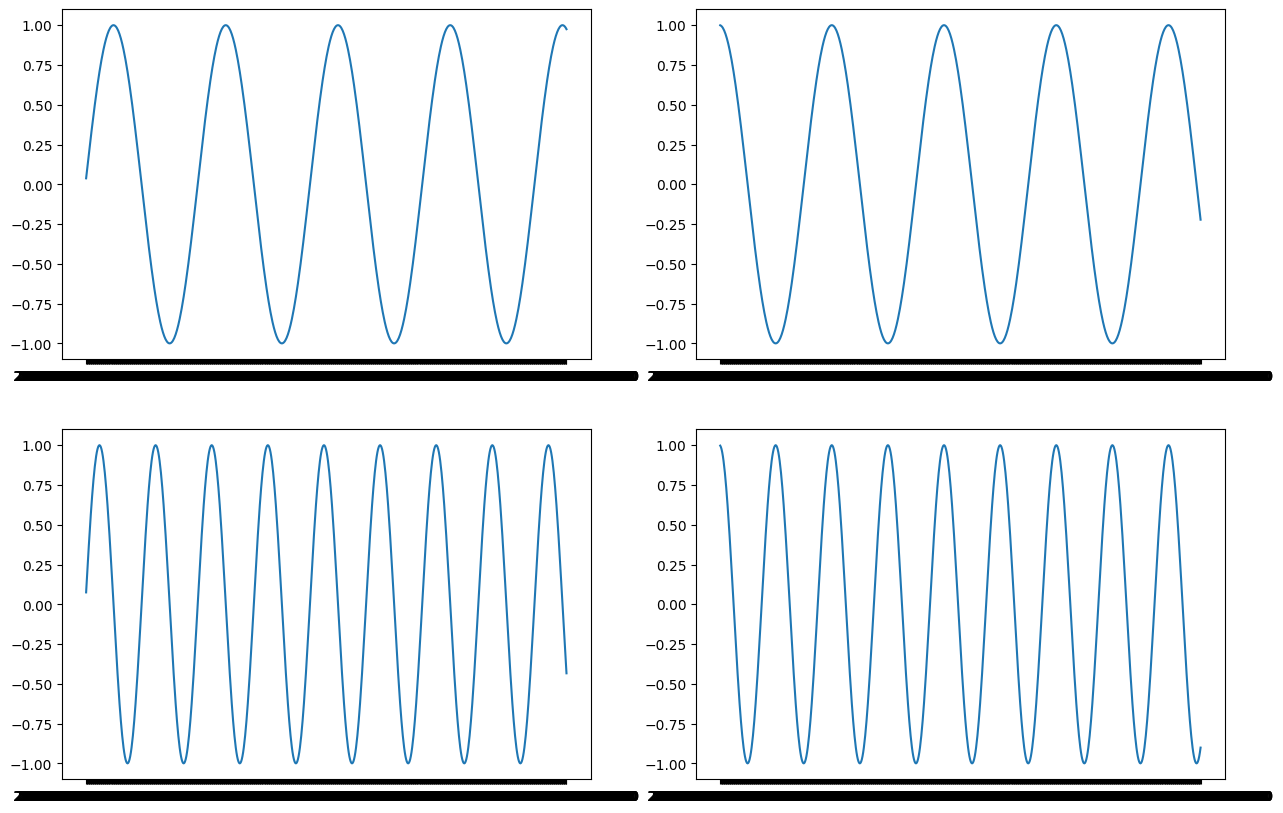

In [10]:
# plot generated fourier series
fig = plt.figure(figsize = (15,10))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.plot(exog.iloc[:720,i])

In [11]:
# arima_model = auto_arima(train_1, seasonal=True, m=24, exogenous=exog_train)
# arima_model.summary()

In [12]:
# in_sample_pred = arima_model.predict_in_sample(pd.DataFrame(train_1))

# # plot in-sample fitted value
# fig = plt.figure(figsize = (15,8))
# plt.plot(train_1)
# plt.plot(in_sample_pred.values, c = 'green')
# plt.legend(['true','pred'])

In [13]:
# # One week forecast
# fig = plt.figure(figsize = (10,5))
# one_week_forecast = arima_model.predict(n_periods=240, exogenous=exog_test)
# one_week_forecast = pd.DataFrame(one_week_forecast, index = test_1.index)

# # Plots on forecast performance

# plot_forecast(test_1,one_week_forecast,(15,8))
# print( mape(test_1,one_week_forecast) )
# # 1 Fourier term as exogenous variables. --> MAPE = 11.6%
# # 2 Fourier terms as exogenous variables. --> MAPE = 10.6%, better

### Moving window training framework
* The data contains 2640 hours = 24 hr/day * 110 days. 15 weeks + 5 days  
* We use four weeks as training window and make one-week-ahead forecast. The last forecast should be adjusted to 5 days.  
* There are total 12 batches, each contains 24*7*4 = 672 entries.  

In [15]:
train_len = 24*7*4
step = 24*7

k = 0   # cluster 0
num_batch = int(np.ceil((dat_pred.shape[1]-train_len)/step))

pred_k = pd.DataFrame() # store forecast data

# prepare fourier variables
four_terms = FourierFeaturizer(168,2)
y_prime, exog = four_terms.fit_transform(dat_pred.iloc[k])
exog['date'] = y_prime.index      # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = 'H'
exog = exog.drop(columns=['date'])

for i in range(num_batch):  # for each training window
    print('training window: ', i)
    
    # prepare train and test data
    train_idx = np.arange(step*i, train_len+step*i)
    test_idx = np.arange(train_len+step*i, min(train_len+step*(i+1),dat_pred.shape[1]) )   # use min to handle the last week
    train = dat_pred.iloc[k,train_idx]
    test = dat_pred.iloc[k,test_idx]
    
    # fourier variables for train and test
    exog_train = exog.iloc[train_idx]
    exog_test = exog.iloc[test_idx]
    
    # SARIMAX model
    arima_model = auto_arima(train, seasonal=True, m=24, exogenous=exog_train)
    pred_tmp = arima_model.predict(n_periods = min(168,len(test)), exogenous=exog_test)
    pred_tmp = pd.DataFrame(pred_tmp, index = test.index)
    pred_k = pd.concat([pred_k, pred_tmp])
    
pred_k    

training window:  0
training window:  1
training window:  2
training window:  3
training window:  4
training window:  5
training window:  6
training window:  7
training window:  8
training window:  9


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(5,0,0)(2,0,1)[24]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Libra

training window:  10
training window:  11


,0
2016-01-29 00:00:00,39.871120
2016-01-29 01:00:00,37.323299
2016-01-29 02:00:00,38.169115
2016-01-29 03:00:00,39.135686
2016-01-29 04:00:00,39.359143
...,...
2016-04-19 19:00:00,78.566978
2016-04-19 20:00:00,75.190425
2016-04-19 21:00:00,71.063265
2016-04-19 22:00:00,63.420740


In [16]:
# pred_k.to_csv('pred_cluster_1_SARIMAX.csv')

In [18]:
def plot_forecast(true,pred,figsize):
    fig = plt.figure(figsize = figsize)
    plt.plot(true, label='True')
    plt.plot(pred, label='Forecast')
    plt.legend()

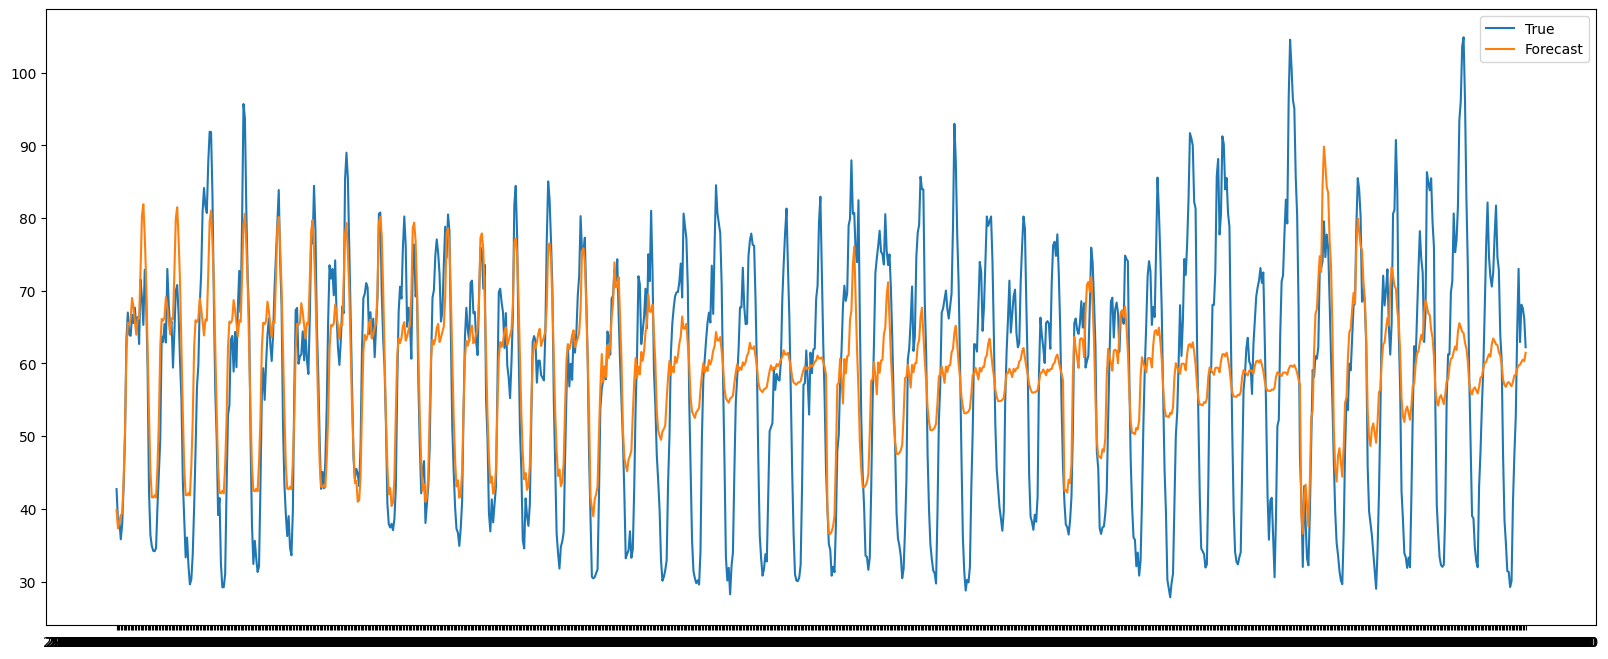

In [19]:
# Visualize the forecast value
true_k = dat_pred.iloc[k,train_len:]
plot_forecast(true_k[:1000],pred_k[:1000],(20,8))

In [20]:
# calculate MAPE
def print_metric(true,pred):
    m = mape(true,pred)
    print('MAPE:', m)
    print('accuracy: {:.2f}%'.format((1-m)*100))

In [21]:
# four weeks training window
print_metric(true_k,pred_k)

MAPE: 0.1969326615848355
accuracy: 80.31%


The prediction diminishes at some point, which significantly reduces the prediction accuracy.

# TBATS

TBATS is short for: 
* Trigonometric seasonality
* Box-Cox transformation
* ARMA errors
* Trend
* Seasonal components. 

TBATS was designed to forecast time series with multiple seasonal periods.

In [25]:
# ! pip install TBATS

In [26]:
from tbats import TBATS

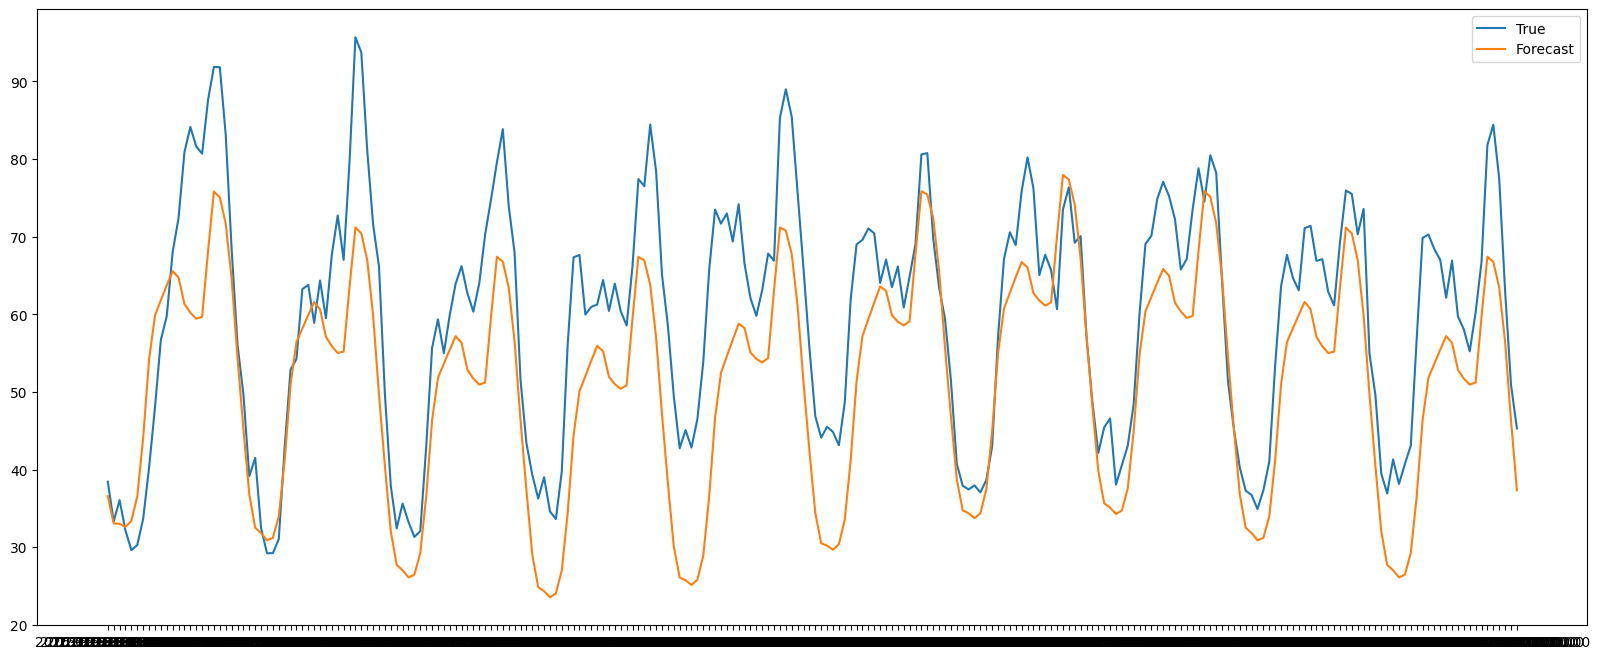

In [27]:
# sample analysis
estimator = TBATS(
    seasonal_periods=[24, 168],
    use_arma_errors=False,  # shall try only models without ARMA
    use_box_cox=False  # will not use Box-Cox
#     n_jobs=1      # use single core if paralell computing failed
)
fitted_model = estimator.fit(train_1)
pred = fitted_model.forecast(steps=240)
plot_forecast(test_1, pred,(20,8))

In [28]:
# TBATS prediction using moving window
# four weeks of training data
# one-week-ahead forecast
train_len = 24*7*4
step = 24*7
k = 0   # cluster 0
num_batch = int(np.ceil((dat_pred.shape[1]-train_len)/step))

pred_k_tb = pd.DataFrame()  # store forecast data

for i in range(num_batch):  # for each training window
    print('training window: ', i)
    
    # prepare train and test data
    train_idx = np.arange(step*i, train_len+step*i)
    test_idx = np.arange(train_len+step*i, min(train_len+step*(i+1),dat_pred.shape[1]) )   # use min to handle the last week
    train = dat_pred.iloc[k,train_idx]
    test = dat_pred.iloc[k,test_idx]
    
    # TBATS
    estimator = TBATS(seasonal_periods=[24, 168], use_arma_errors=False, use_box_cox=False) 
    fitted_model = estimator.fit(train)
    pred_tmp = fitted_model.forecast(steps=min(step,len(test)))
    pred_tmp = pd.DataFrame(pred_tmp, index = test.index)
    pred_k_tb = pd.concat([pred_k_tb, pred_tmp])

training window:  0
training window:  1
training window:  2
training window:  3
training window:  4
training window:  5
training window:  6
training window:  7
training window:  8
training window:  9
training window:  10
training window:  11


MAPE: 0.12900768927793899
accuracy: 87.10%


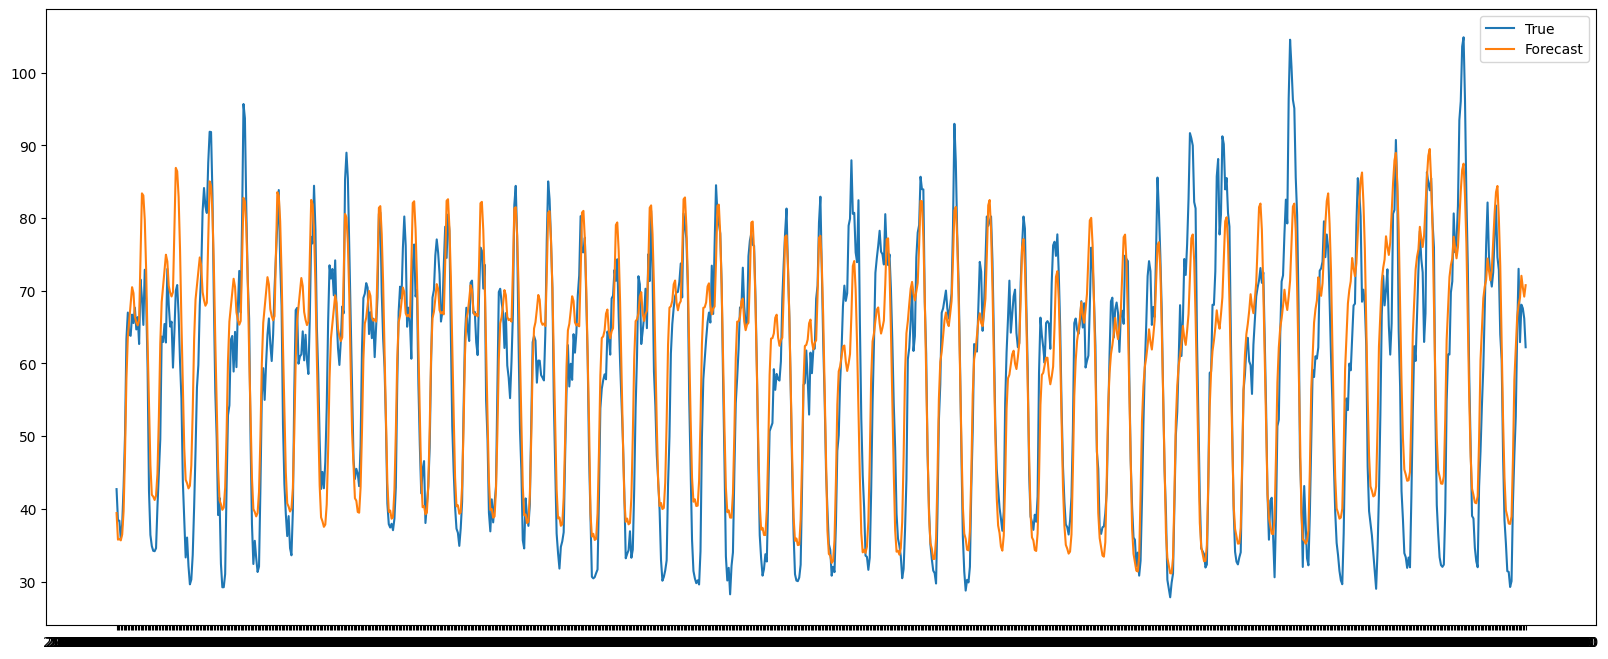

In [29]:
true_k = dat_pred.iloc[k,train_len:]
print_metric(true_k,pred_k_tb)
plot_forecast(true_k[:1000],pred_k_tb[:1000],(20,8))

From the plot we see that the TBATS method provides a good fit, and avoids the problem of vanishing predictions. The MAPE drops from 17% to 13%, which demonstrate the robustness of the TBATS model.

In [30]:
# we make the granularity finer and fit one-day-ahead prediction and see if the MAPE further decreases
# still four weeks of training data
# one-day-ahead forecast

# 110 days --> 28 days for train, 82 batches

train_len = 24*7*4
step = 24 
k = 0   # cluster 0
num_batch = int(np.ceil((dat_pred.shape[1]-train_len)/step))

pred_k_tb = pd.DataFrame()  # store forecast data

for i in range(num_batch):  # for each training window
    if i % 10 == 0:
        print('training window: ', i)
    
    # prepare train and test data
    train_idx = np.arange(step*i, train_len+step*i)
    test_idx = np.arange(train_len+step*i, min(train_len+step*(i+1),dat_pred.shape[1]) )   # use min to handle the last week
    train = dat_pred.iloc[k,train_idx]
    test = dat_pred.iloc[k,test_idx]
#     print(train.shape, test.shape)
    
    # TBATS
    estimator = TBATS(seasonal_periods=[24, 168], use_arma_errors=False, use_box_cox=False) 
    fitted_model = estimator.fit(train)
    pred_tmp = fitted_model.forecast(steps=min(step,len(test)))
    pred_tmp = pd.DataFrame(pred_tmp, index = test.index)
    pred_k_tb = pd.concat([pred_k_tb, pred_tmp])

training window:  0
training window:  10
training window:  20
training window:  30
training window:  40
training window:  50
training window:  60
training window:  70
training window:  80


MAPE: 0.1045677051354218
accuracy: 89.54%


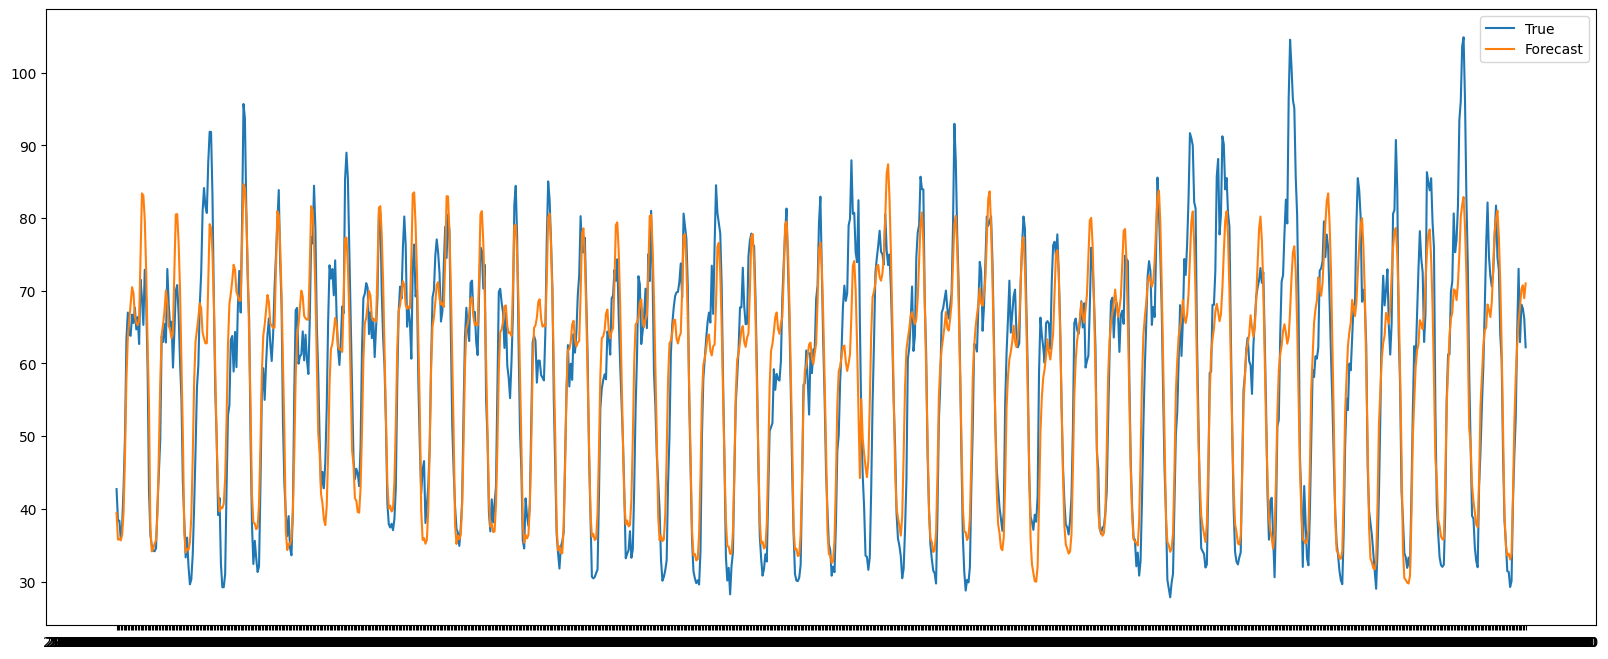

In [31]:
print_metric(true_k,pred_k_tb)
plot_forecast(true_k[:1000],pred_k_tb[:1000],(20,8))

* MAPE decreased from 12.90% to 10.45%, but computation time increases significantly.
* How you choose the model depends on how to perceive the tradeoff between precision v.s. computation complexity

In this notebook, we only select one cluster for analysis and visualization. The file **train_TBATS.py** fits all the clusters and writes the results into **pred_results_TB_1d.csv**(one-day-ahead forecast) and **pred_results_TB_1w.csv**(one-week-ahead forecast). Finally, the comparison of time series model and neural network model is in the notebook **Model-Comparison**.